# Project Overview

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

## Objective

In this notebook, I will perform EDA on the data bike sharing data before forecasting the bike rental demand using ______

# Dependencies

In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# Data Exploration

In [70]:
bike_data = pd.read_csv("../data/train.csv")

Let's take a glimps at the first few records. 

In [36]:
bike_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [37]:
def data_analysis(df):
    '''
    Takes in a dataframe as input and prints out the Shape, Column Names, Data Types,
    and Null Values
    '''
    print("Data Shape:")
    print(df.shape, end = "\n\n")
    print("Column Names:")
    print(df.columns, end = "\n\n")
    print("Data Types:")
    print(df.dtypes, end = "\n\n")
    print("Null Values:")
    print(df.isnull().sum())


In [38]:
data_analysis(bike_data)

Data Shape:
(10886, 12)

Column Names:
Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

Data Types:
datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

Null Values:
datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64


Looks like there are no null values and one Object value.

The description of the columns are as follows:

datetime - hourly date + timestamp<br>
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter<br>
holiday - whether the day is considered a holiday<br>
workingday - whether the day is neither a weekend nor holiday<br>
weather - <br>1: Clear, Few clouds, Partly cloudy<br>
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist<br>
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds<br>
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog <br>
temp - temperature in Celsius<br>
atemp - "feels like" temperature in Celsius<br>
humidity - relative humidity<br>
windspeed - wind speed<br>
casual - number of non-registered user rentals initiated<br>
registered - number of registered user rentals initiated<br>
count - number of total rentals<br>

## Univariate Analyses

Looking at the description, the following columns are categorical variables: ['season', 'holiday', 'workingday', 'weather'].

Also, seems like workday / holidays may have some correlation. We'll keep note of that

Let's do a univariate analysis on these variables first

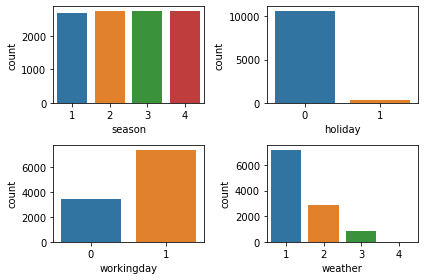

In [52]:
categ_cols = ['season', 'holiday', 'workingday', 'weather']

for counter, col in enumerate(categ_cols, 1):
    plt.subplot(2, 2, counter)
    sns.countplot(col, data = bike_data)
    
plt.tight_layout()

Note that the y axes on the subplots above is for the number of records, not bike demans

Inferences:
* The records are spread out among the seasons
* Most weathers are clear, few clouds, party cloudy

Next, let's look at the continous variables

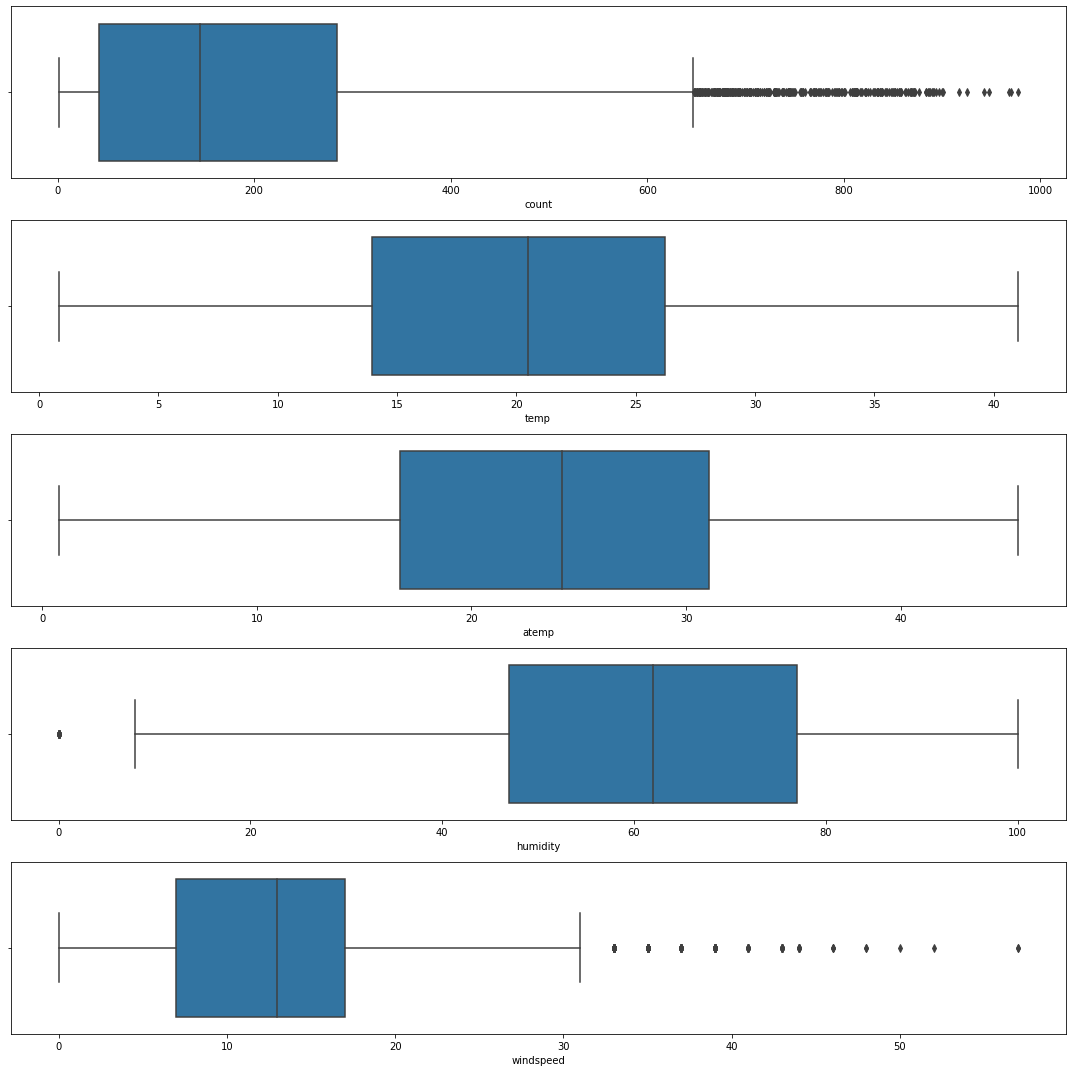

In [66]:
cont_cols = ['count', 'temp', 'atemp', 'humidity', 'windspeed']

fig, axs = plt.subplots(5, figsize = (15, 15))

for counter, col in enumerate(cont_cols):
    sns.boxplot(col, data = bike_data, ax = axs[counter])


plt.tight_layout()

Inferences:
* count have a lot of outliers. May be useful to only look at those within 3 standard deviations
* windspeed has some outliers beyond 30

## Correlation Analysis

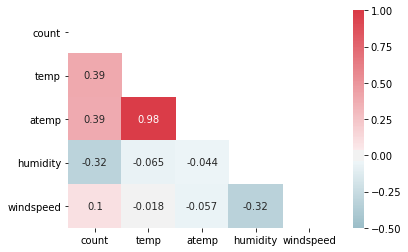

In [148]:
corr = bike_data[cont_cols].corr()
mask = np.triu(np.ones_like(corr, dtype = np.bool))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask = mask, annot = True, cmap = cmap, vmin = -.5, vmax = 1, center = 0)

Looking at the correlation heatmap above:
* atemp and temp are highly correlated, as expected
* windspeed is not really correlated with count

## Feature Engineering

Let's first convert the datetime variable from to datettime and add separate columns 

In [71]:
def pre_process(df):
    """
    Function to preprocess the dataframe, essentially creating new columns, creating
    dummy varibales with OH encoding and removing unnecessary ones.
    """
    new_df = df
    new_df.datetime = df.datetime.apply(lambda x: 
                                                  datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    new_df.hour = df.datetime.apply(lambda x: x.hour)
    new_df.day = df.datetime.apply(lambda x: x.day)
    new_df.month = df.datetime.apply(lambda x: x.month)
    new_df.year = df.datetime.apply(lambda x: x.year)
    
    return new_df